Essential Libraries

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 25
DIR_NAME = "datasets/PlantVillage/Original" 

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_NAME,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 165 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [6]:
print("Dataset Batch Size = ", len(dataset))

Dataset Batch Size =  11


In [7]:
# 80% => training
# 20% => 10% validation, 10% test
# skip first n dataset [n:]
def get_dataset_partitions_tf(ds, train_spilt=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    if(shuffle):
        ds = ds.shuffle(shuffle_size, seed = 12)
    ds_size = len(ds)
    train_size = int(train_spilt * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print("Training Size = ", len(train_ds))
print("Validation Size = ", len(val_ds))
print("Testing Size = ", len(test_ds))

Training Size =  8
Validation Size =  1
Testing Size =  2


In [9]:
# cache the images, using tf prefetch pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
# TF data argumentation: fix contrast, rotation of images by transformation
data_argumentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [12]:
# Convolutional layer = Conv2D
# Pooling layer 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = Sequential([
    resize_and_rescale,
    data_argumentaion,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])
model.build(input_shape=input_shape)

In [12]:
# from patch import CreatePatches
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# inputs = tf.keras.layers.Input( shape=( IMAGE_SIZE , IMAGE_SIZE , CHANNELS ) ) 
# patches = CreatePatches( patch_size=64 )( inputs )
# model = tf.keras.models.Model( inputs , patches )
# model.build(input_shape=input_shape)
# model.summary()

In [13]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = len(class_names)
# model = Sequential([
#     resize_and_rescale,
#     data_argumentaion,
#     layers.TimeDistributed(layers.LSTM(16, return_sequences=True, input_shape=input_shape)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])
# model.build(input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
8/8 [==============================] - 16s 1s/step - loss: 7.5472 - accuracy: 0.1250 - val_loss: 2.4450 - val_accuracy: 0.0625
Epoch 2/25
8/8 [==============================] - 11s 1s/step - loss: 2.3212 - accuracy: 0.0859 - val_loss: 2.2810 - val_accuracy: 0.1250
Epoch 3/25
8/8 [==============================] - 10s 1s/step - loss: 2.2940 - accuracy: 0.1797 - val_loss: 2.2531 - val_accuracy: 0.1875
Epoch 4/25
8/8 [==============================] - 10s 1s/step - loss: 2.2511 - accuracy: 0.1719 - val_loss: 2.1735 - val_accuracy: 0.1250
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 2.1632 - accuracy: 0.2266 - val_loss: 2.1103 - val_accuracy: 0.1250
Epoch 6/25
8/8 [==============================] - 9s 1s/step - loss: 2.0049 - accuracy: 0.2422 - val_loss: 1.9782 - val_accuracy: 0.1875
Epoch 7/25
8/8 [==============================] - 11s 1s/step - loss: 1.8476 - accuracy: 0.4453 - val_loss: 1.6504 - val_accuracy: 0.3125
Epoch 8/25
8/8 [====================

In [16]:
score = model.evaluate(test_ds)

2/2 [==============================] - 1s 303ms/step - loss: 1.1315 - accuracy: 0.7500


In [17]:
# history.params
# history.history['accuracy']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

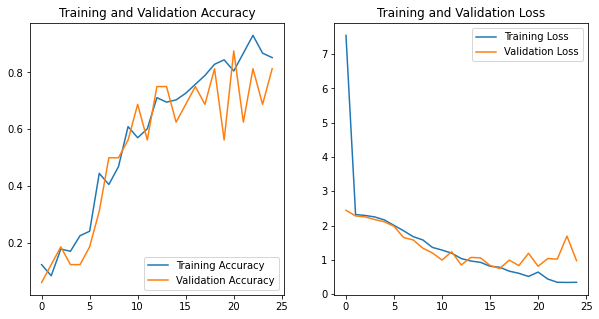

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [20]:
# # Make Predictions
# '''
# for images_batch, labels_batch in test_ds.take(1):
#     first_image = images_batch[0].numpy().astype('uint8')
#     first_label = labels_batch[0]
    
#     print("First image to predict")
#     plt.imshow(first_image)
#     print("actual label:", class_names[first_label])
    
#     batch_prediction = model.predict(images_batch)
#     predicted_class_index = np.argmax(batch_prediction[0])
#     print("Predicted label: ", class_names[predicted_class_index])
# '''

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  #creating a batch
    
    predictions = model.predict(img_array)
    
    predicted_class =  class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


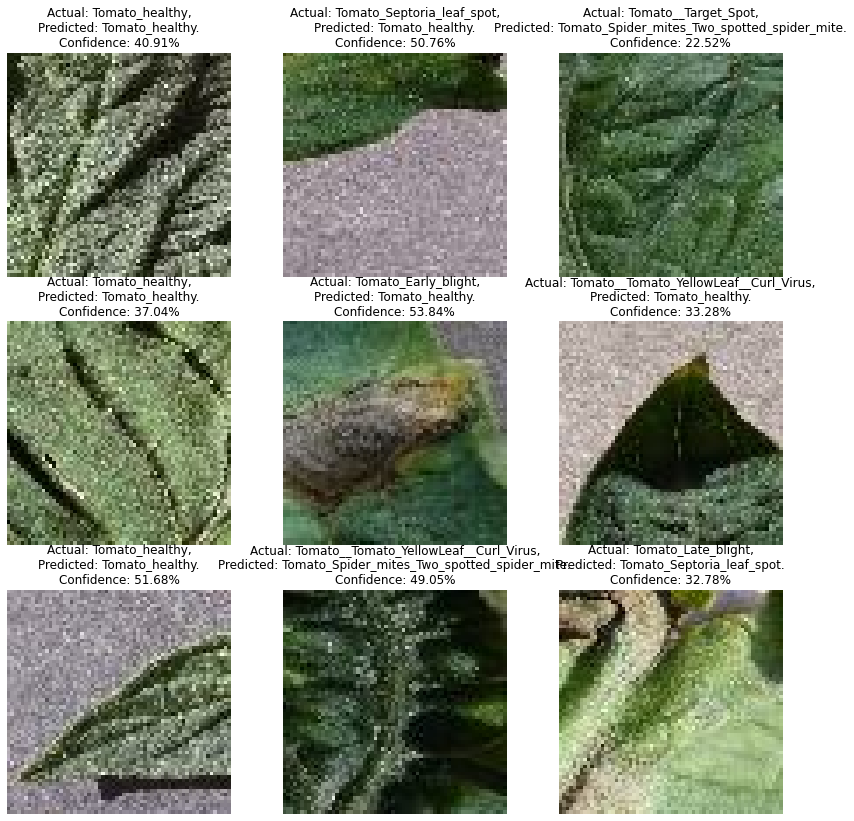

In [22]:
plt.figure(figsize=(14,14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        

In [23]:
# save model
model_version=1
model.save(f"../models/{model_version}",save_format='h5')
# model.save("../models/model1")